In [1]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from utils.data_utils import preprocessing, custom_train_test_split, generate_cm


count      23752
unique      4900
top       39 900
freq         293
Name: price_pln, dtype: object


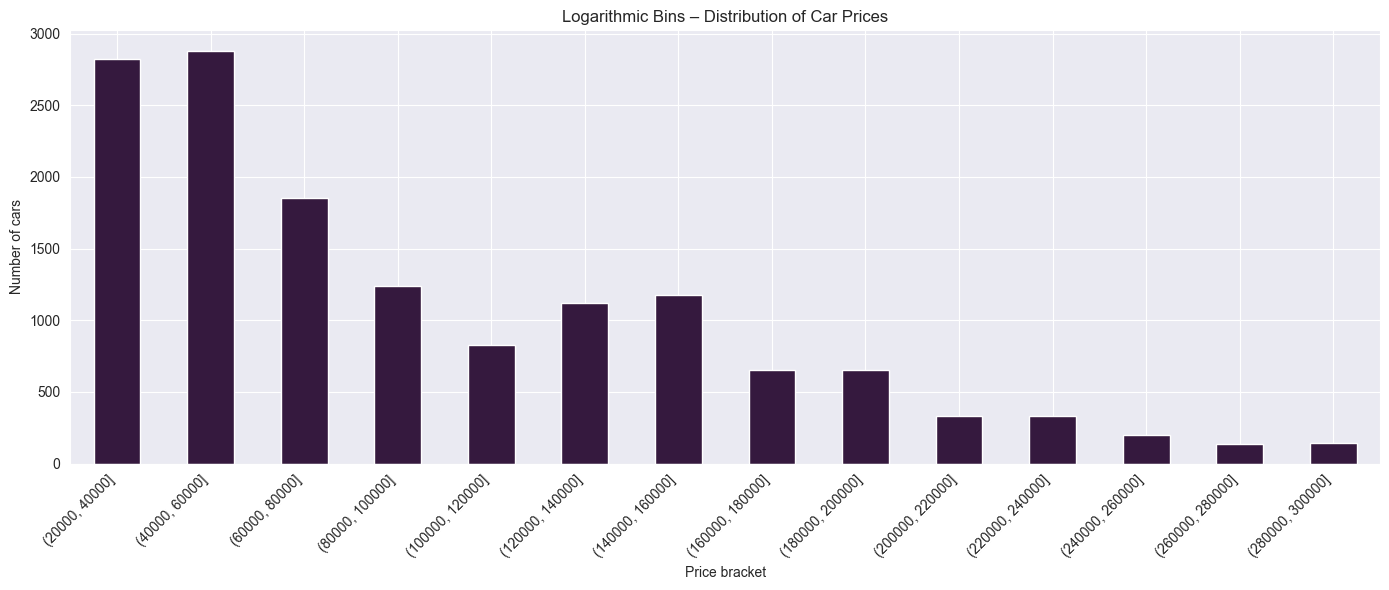

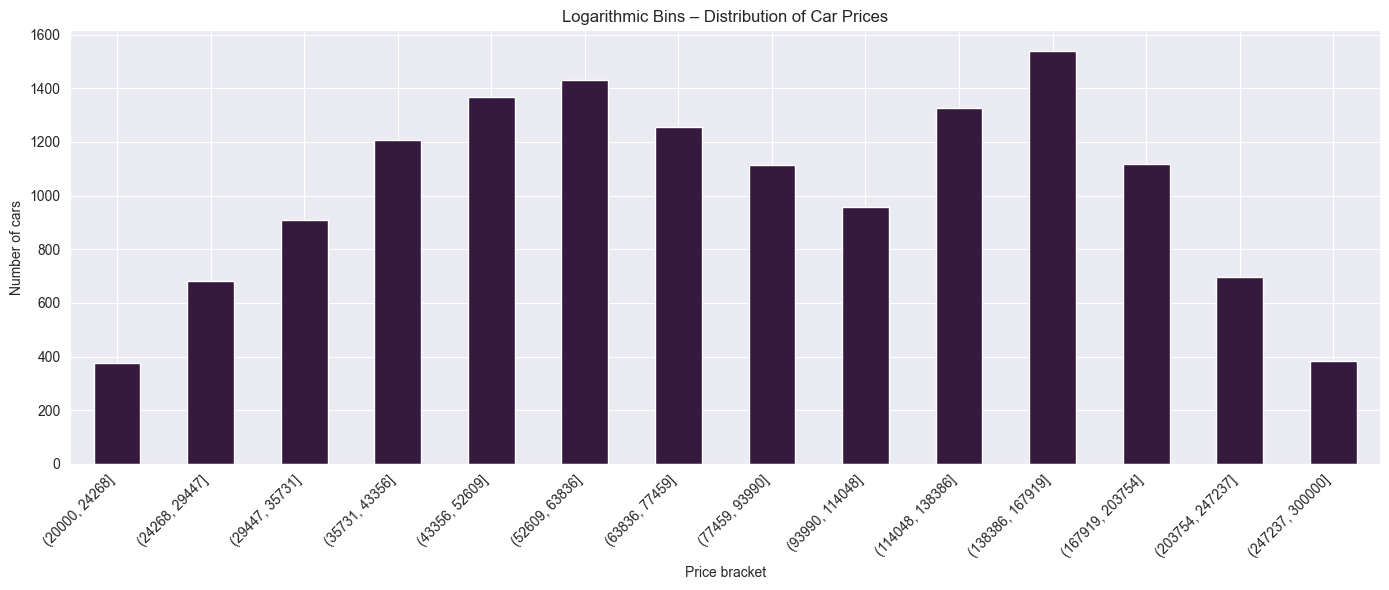

In [2]:
from utils.data_utils import plot_hist
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

clean_df = pd.read_csv("../cleaned_data.csv", sep=";")

sns.set_palette("rocket")

with pd.option_context("display.float_format", "{:.1f}".format):
    print(
        clean_df["price_pln"].describe(
            percentiles=[0.1, 0.25, 0.5, 0.75, 0.8, 0.9, 0.95]
        )
    )

df, lin_bins, log_bins = preprocessing(clean_df, step = 20_000, min_price = 20_000, max_price = 300_000)
prices = df["price_pln"].values

# --- linear bins ---
plot_hist(df, bins=lin_bins, title="Linear Bins – Distribution of Car Prices",
          xlabel="Number of cars", ylabel="Linear Bins")

# --- logarithmic bins ---
plot_hist(df, bins=log_bins, title="Logarithmic Bins – Distribution of Car Prices",
          xlabel="Number of cars", ylabel="Logarithmic Bins")

In [3]:
X_train, X_test, y_train, y_test = custom_train_test_split(df, log_bins, test_size=0.2, random_state=42)

print(df.describe().apply(lambda s: s.apply('{0:.5f}'.format)))
print(df.head())
print(y_test)


Number of classes: 14
             seats         year     capacity        power        mileage  \
count  14367.00000  14367.00000  14367.00000  14367.00000    14367.00000   
mean       3.47609   2019.64620   2108.65295    141.79349   133768.04455   
std        1.45170      5.26188    545.65208     43.03065   132486.19534   
min        1.00000   1955.00000      1.00000     15.00000        1.00000   
25%        3.00000   2017.00000   1968.00000    125.00000       10.00000   
50%        3.00000   2020.00000   2000.00000    140.00000   125000.00000   
75%        3.00000   2025.00000   2287.00000    163.00000   216000.00000   
max        9.00000   2026.00000  21433.00000   2299.00000  2060400.00000   

          price_pln    price_bin  
count   14367.00000  14367.00000  
mean    97605.03530      6.58982  
std     63710.85910      3.45420  
min     20000.00000      0.00000  
25%     45900.00000      4.00000  
50%     76400.00000      6.00000  
75%    140833.77000     10.00000  
max    299999

In [4]:
from sklearn.decomposition import TruncatedSVD

with open("../utils/polish_stopwords.txt", "r") as f:
    polish_stopwords = [word.strip() for word in f]   # <- LIST, not SET

# --- 5) pipeline (TFIDF ONLY) ---
pipeline = Pipeline([
    ("tfidf", TfidfVectorizer(
        max_features=30000,
        ngram_range=(1,2),
        min_df=2,
        stop_words=polish_stopwords
    )),
    ("svd", TruncatedSVD(n_components=200, random_state=42)),
    ("clf", DecisionTreeClassifier(random_state=42))
])



In [5]:
# --- 6) grid search ---
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

param_grid = {
    "clf__max_depth": [6, 10, 20, None],
    "clf__min_samples_leaf": [1, 3, 5]
}


grid = GridSearchCV(
    pipeline,
    param_grid,
    cv=cv,
    scoring='accuracy',
    verbose=2,
    n_jobs=1,        # set to 1 to avoid loky worker issues; change if you have stable multiprocessing
    refit=True
)

grid.fit(X_train, y_train)

print("Best params:", grid.best_params_)
print("Best CV score (mean accuracy):", grid.best_score_)


Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END ..........clf__max_depth=6, clf__min_samples_leaf=1; total time=   6.9s
[CV] END ..........clf__max_depth=6, clf__min_samples_leaf=1; total time=   6.7s
[CV] END ..........clf__max_depth=6, clf__min_samples_leaf=1; total time=   6.8s
[CV] END ..........clf__max_depth=6, clf__min_samples_leaf=1; total time=   7.6s
[CV] END ..........clf__max_depth=6, clf__min_samples_leaf=1; total time=   7.8s
[CV] END ..........clf__max_depth=6, clf__min_samples_leaf=3; total time=   6.9s
[CV] END ..........clf__max_depth=6, clf__min_samples_leaf=3; total time=   6.9s
[CV] END ..........clf__max_depth=6, clf__min_samples_leaf=3; total time=   6.5s
[CV] END ..........clf__max_depth=6, clf__min_samples_leaf=3; total time=   6.9s
[CV] END ..........clf__max_depth=6, clf__min_samples_leaf=3; total time=   7.1s
[CV] END ..........clf__max_depth=6, clf__min_samples_leaf=5; total time=   6.8s
[CV] END ..........clf__max_depth=6, clf__min_sa

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, StratifiedKFold

with open("../utils/polish_stopwords.txt", "r") as f:
    polish_stopwords = [word.strip() for word in f]   # <- LIST, not SET


pipeline = Pipeline([
    ("tfidf", TfidfVectorizer(max_features=20000, ngram_range=(1,2), min_df=3, stop_words=polish_stopwords)),
    ("clf", LogisticRegression(max_iter=5000, class_weight='balanced'))
])

param_grid = {
    "tfidf__max_features": [10000, 20000],
    "tfidf__ngram_range": [(1,1), (1,2)],
    "clf__C": [0.01, 0.1, 1, 10]
}

grid = GridSearchCV(pipeline, param_grid, cv=StratifiedKFold(5), n_jobs=1, scoring='accuracy', verbose=2)
grid.fit(X_train, y_train)
print("best", grid.best_score_, grid.best_params_)


Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END clf__C=0.01, tfidf__max_features=10000, tfidf__ngram_range=(1, 1); total time=   1.2s
[CV] END clf__C=0.01, tfidf__max_features=10000, tfidf__ngram_range=(1, 1); total time=   1.3s
[CV] END clf__C=0.01, tfidf__max_features=10000, tfidf__ngram_range=(1, 1); total time=   1.2s
[CV] END clf__C=0.01, tfidf__max_features=10000, tfidf__ngram_range=(1, 1); total time=   1.2s
[CV] END clf__C=0.01, tfidf__max_features=10000, tfidf__ngram_range=(1, 1); total time=   1.3s
[CV] END clf__C=0.01, tfidf__max_features=10000, tfidf__ngram_range=(1, 2); total time=   3.0s
[CV] END clf__C=0.01, tfidf__max_features=10000, tfidf__ngram_range=(1, 2); total time=   2.9s
[CV] END clf__C=0.01, tfidf__max_features=10000, tfidf__ngram_range=(1, 2); total time=   2.8s
[CV] END clf__C=0.01, tfidf__max_features=10000, tfidf__ngram_range=(1, 2); total time=   2.8s
[CV] END clf__C=0.01, tfidf__max_features=10000, tfidf__ngram_range=(1, 2); total ti

In [7]:
# --- 7) evaluate on test set ---
best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)
print("Test accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, zero_division=0))


Test accuracy: 0.4846903270702853
              precision    recall  f1-score   support

         0.0       0.34      0.35      0.34        81
         1.0       0.38      0.45      0.42       128
         2.0       0.31      0.41      0.35       155
         3.0       0.35      0.35      0.35       252
         4.0       0.45      0.40      0.42       288
         5.0       0.43      0.39      0.41       282
         6.0       0.42      0.47      0.45       238
         7.0       0.42      0.40      0.41       234
         8.0       0.49      0.48      0.49       202
         9.0       0.62      0.61      0.62       278
        10.0       0.70      0.60      0.64       301
        11.0       0.61      0.64      0.62       224
        12.0       0.61      0.64      0.62       138
        13.0       0.60      0.63      0.61        73

    accuracy                           0.48      2874
   macro avg       0.48      0.49      0.48      2874
weighted avg       0.49      0.48      0.49   

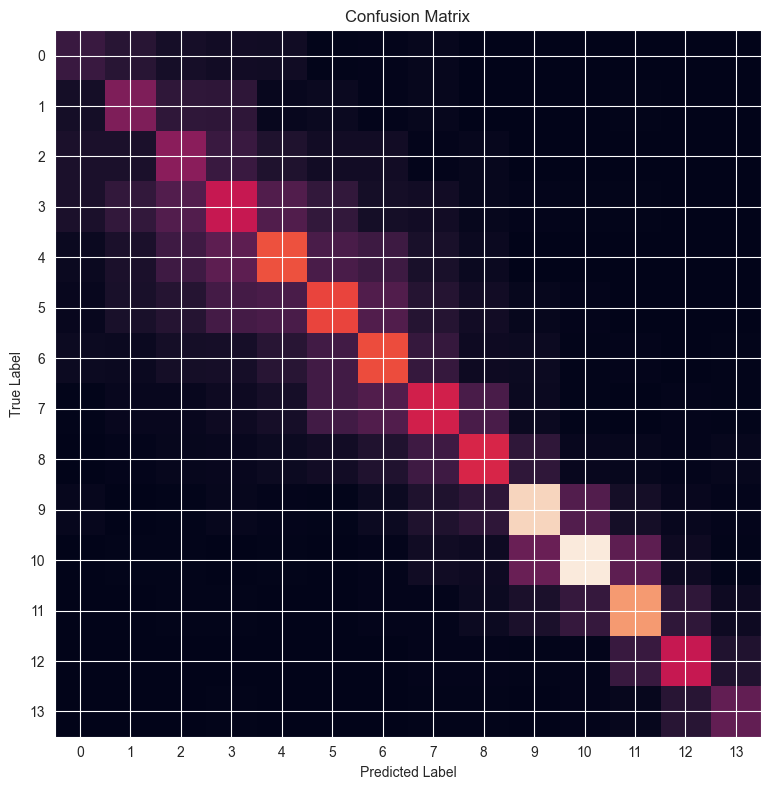

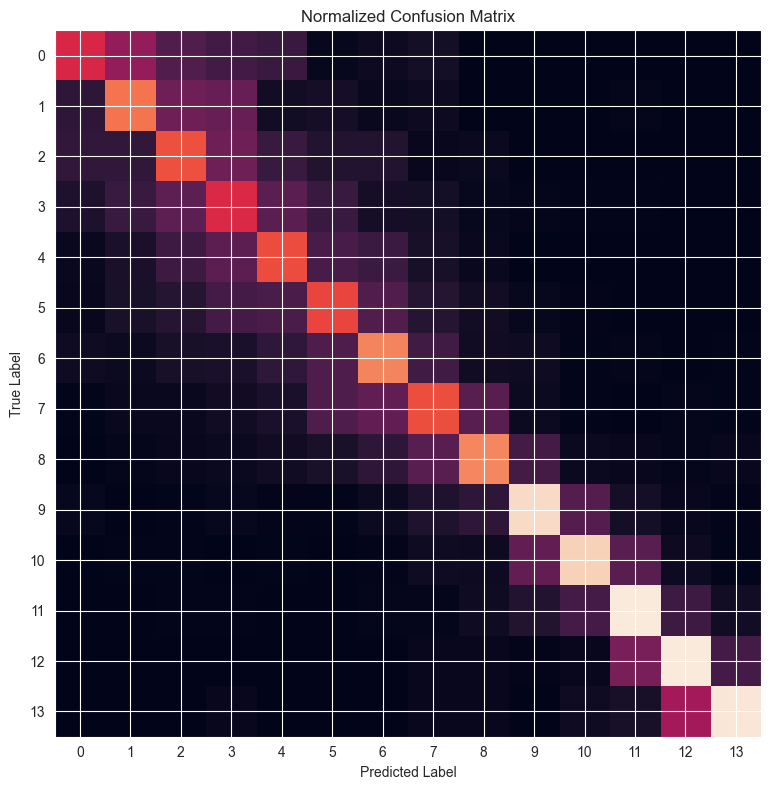

In [8]:
from utils.data_utils import plot_cm
cm, cm_normalized = generate_cm(y_test, y_pred)

plot_cm(cm, title="Confusion Matrix")
plot_cm(cm_normalized, title="Normalized Confusion Matrix")


In [10]:
# --- 8) helper: convert predicted bin index to price range ---
def bin_to_range(bins, bin_idx):
    bin_idx = int(bin_idx)  # ensure integer
    low = int(bins[bin_idx])
    high = int(bins[bin_idx + 1] - 1)
    return (low, high)

# predict for new descriptions
new_descriptions = ["Excellent condition car, hardly used, my favourite BMW car I've ever had."]
pred_bins = best_model.predict(new_descriptions).ravel()  # ensures 1D array
print("Predicted bin indices:", pred_bins)
print("Predicted price ranges:", [bin_to_range(log_bins, b) for b in pred_bins])


Predicted bin indices: [1.]
Predicted price ranges: [(24268, 29446)]
